<a href="https://colab.research.google.com/github/lokylam/example_work/blob/main/DeepMLP_From_Pupil_Activity_to_Neural_Spiking_PCs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Essential Libraries
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import pathlib
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import pickle
import seaborn as sns
from copy import deepcopy
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from IPython.display import display
from google.colab import drive

In [2]:
# Mount Google Drive to access files and directories
drive.mount('/content/gdrive')
folder_path = '/content/gdrive/My Drive/models_nma_project/'

Mounted at /content/gdrive


In [3]:
# Check if a CUDA-compatible GPU is available; if not, use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [5]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

In [6]:
data = alldat[12] # Select Neural activity from Session 13
data['spks'].shape # Get the shape of the 'spks' attribute within the selected data: we have 983 neurons,300 trials and 250 time Points in this session


(983, 300, 250)

In [7]:
# @title Average Spike Data
avg_spike = data['spks'].mean(axis = 2).T
avg_spike.shape

(300, 983)

In [8]:
# @title Average Pupil Data
avg_pupil = alldat[12]['pupil'].mean(axis=2).T
avg_pupil.shape

(300, 3)

In [9]:
# @title Split Data into train, validatation and test sets
y = avg_pupil.copy()
x = avg_spike.copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=2) # 80% train, 20% test
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 4) # 80% train, 20% validation

In [10]:
# @title Applying PCA on Neural Data
model_pca = PCA(n_components = 40)
model_pca.fit(x_train)

PCA(n_components=40)

In [11]:
# @title Explained Variance in Each Component(%)
variance_percentage = (model_pca.explained_variance_ratio_)*100
print(f'Each Component Variance : {variance_percentage}')
tot_var = variance_percentage.sum()
print('')
print(f'Total Explained Variance is:{tot_var}')

Each Component Variance : [21.10009089 12.60269134  8.29114939  4.88959217  4.59061212  3.54574288
  2.96845251  2.47366609  2.14937328  1.98667533  1.85283695  1.58346848
  1.43068087  1.30176125  1.24852565  1.16959297  1.10206323  1.02432517
  0.92453651  0.88684166  0.79396232  0.77720798  0.72859026  0.65319798
  0.64532164  0.59929944  0.55819802  0.52826328  0.51230688  0.47490472
  0.4423031   0.42294908  0.40086432  0.38212153  0.37204461  0.35779257
  0.34735553  0.33441948  0.32962951  0.32085458]

Total Explained Variance is:87.10426555142175


In [12]:
# @title PCA Components
PCs = model_pca.transform(x_train)
PCs.shape

(192, 40)

<ipython-input-13-916c76523b9b>:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(PCs[:,0],PCs[:,1],cmap='RdBu')


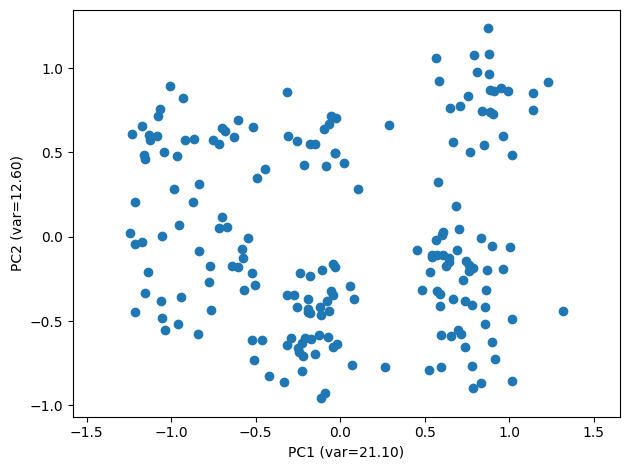

In [13]:
plt.scatter(PCs[:,0],PCs[:,1],cmap='RdBu')
plt.xlabel("PC1 (var=%.2f)" % variance_percentage[0])
plt.ylabel('PC2 (var=%.2f)' % variance_percentage[1])
plt.axis('equal')
plt.tight_layout()

In [14]:
# Uncomment if we are predicting neural PCs from pupil dynamics
# y_train = model_pca.transform(y_train)
# y_val = model_pca.transform(y_val)
# y_test = model_pca.transform(y_test)

# Uncomment if we are predicting pupil dynamics from neural PCs
x_train = model_pca.transform(x_train)
x_val = model_pca.transform(x_val)
x_test = model_pca.transform(x_test)

In [15]:
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)
x_val = torch.Tensor(x_val)
y_val = torch.Tensor(y_val)

In [16]:
# @title Define MLP
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dims, actv):

    super(MLP, self).__init__()

    self.mlp = nn.Sequential() # initializes an empty nn.Sequential() container, which will hold the layers of the MLP in a sequential manner.

    if len(hidden_dims) > 0:
      self.mlp.add_module('input layer', nn.Linear(input_dim, hidden_dims[0]))
    else:
      self.mlp.add_module('input layer', nn.Linear(input_dim, output_dim))

    if len(hidden_dims) == 1:
      self.mlp.add_module('actv 1', actv)
      self.mlp.add_module('hidden layer 0', nn.Linear(hidden_dims[0], output_dim))
    elif len(hidden_dims) > 1:
      for i in range(1, len(hidden_dims)):
        self.mlp.add_module('actv {}'.format(i), actv)
        self.mlp.add_module('hidden layer {}'.format(i), nn.Linear(hidden_dims[i-1], hidden_dims[i]))
      self.mlp.add_module('actv {}'.format(len(hidden_dims)), actv)
      self.mlp.add_module('output layer', nn.Linear(hidden_dims[-1], output_dim))

  def forward(self, x):

    output = self.mlp(x)

    return output


In [17]:
# Creat mini-batches for training
train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

val_dataset = TensorDataset(x_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size = 64, shuffle = True)

test_dataset = TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = True)


In [18]:
# @title Check shapes of input and output

batch = next(iter(train_dataloader))

input, output = batch

print("Input shape:", input.shape)
print("Output shape:", output.shape)

print(x_val.shape)
print(y_val.shape)

Input shape: torch.Size([64, 40])
Output shape: torch.Size([64, 3])
torch.Size([48, 40])
torch.Size([48, 3])


In [19]:
# @title Define training function
def train(model, loss, optimizer):

  current_loss = 0.0

  model.train()

  for input, output in train_dataloader:
        # make sure datatypes of input and output are correct
        input = input.float()
        output = output.float()
        optimizer.zero_grad()

        prediction = model(input)
        batch_loss = loss(prediction, output)

        batch_loss.backward()

        optimizer.step()

        current_loss += batch_loss.detach().item()

  return current_loss, model


In [20]:
# @title Define test functions

from sklearn.metrics import r2_score

# Calculate loss between the model's predictions and actual target values
def test(x, y, model, loss):

    model.eval()

    prediction = model(x)

    val_loss = loss(prediction, y)

    return val_loss.detach().item()

# Calculate R2-score (goodness-of-fit between predicted and actual values)
def test_r2(x, y, model, loss):

    model.eval()

    prediction = model(x)

    return r2_score(prediction.detach().numpy().flatten(),y.detach().numpy().flatten())


In [21]:
# @title Define early stopping function
def early_stopping(num_epochs, model, train_loader, val_loader, model_id = ''): # model_id default is empty


  best_loss = np.inf
  best_epoch = 0

  # Number of successive epochs that you want to wait before stopping training process
  patience = 50

  # Keeps track of number of epochs during which the val_acc was less than best_acc
  wait = 0

  train_losses = []
  val_losses = []

  for num_epoch in tqdm(range(num_epochs)):

    # Training loss
    current_loss, model = train(model, loss, optimizer)
    # print(current_loss)

    # Validation loss
    val_loss = test(x_val, y_val, model, loss)

    if (val_loss < best_loss):
      best_loss = val_loss
      best_epoch = num_epoch

      best_model = 'best deep MLP_2*32_StoP{}'.format(model_id)
      checkpoint_file_path = folder_path + best_model
      torch.save(model.state_dict(), checkpoint_file_path)

      wait = 0
    else:
      wait += 1

    if (wait > patience):
      print(f'Early stopped on epoch: {num_epoch}')
      break

    train_losses.append(current_loss)
    val_losses.append(val_loss)

  return train_losses, val_losses, model, best_epoch, best_loss


  0%|          | 0/1000 [00:00<?, ?it/s]

Early stopped on epoch: 348
Maximum Validation Accuracy is reached at epoch: 297


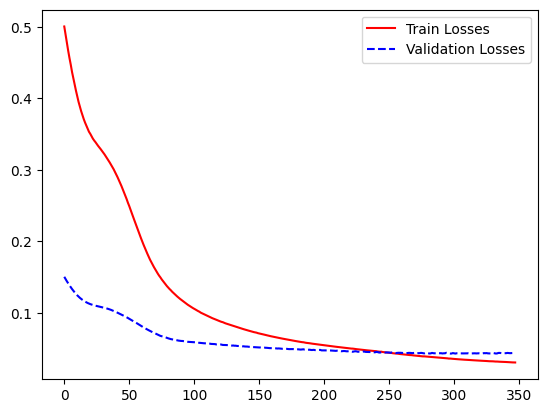

  0%|          | 0/1000 [00:00<?, ?it/s]

Early stopped on epoch: 345
Maximum Validation Accuracy is reached at epoch: 294


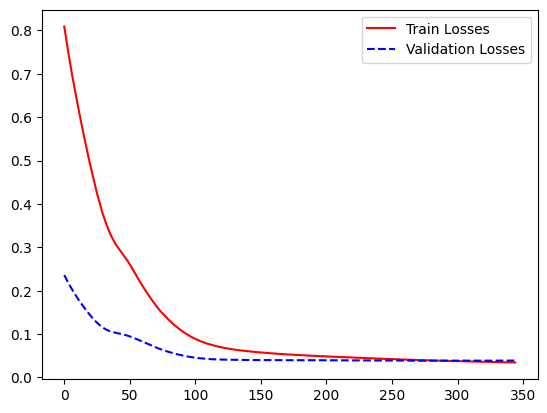

  0%|          | 0/1000 [00:00<?, ?it/s]

Early stopped on epoch: 330
Maximum Validation Accuracy is reached at epoch: 279


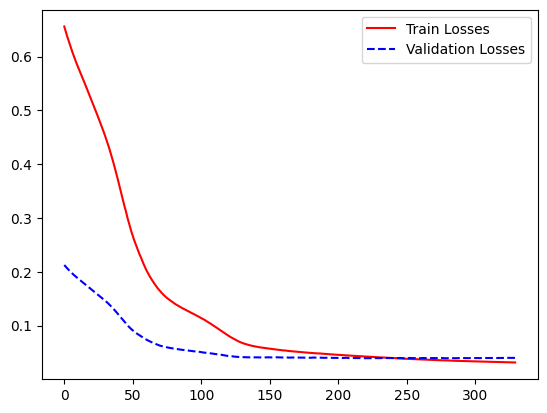

  0%|          | 0/1000 [00:00<?, ?it/s]

Early stopped on epoch: 182
Maximum Validation Accuracy is reached at epoch: 131


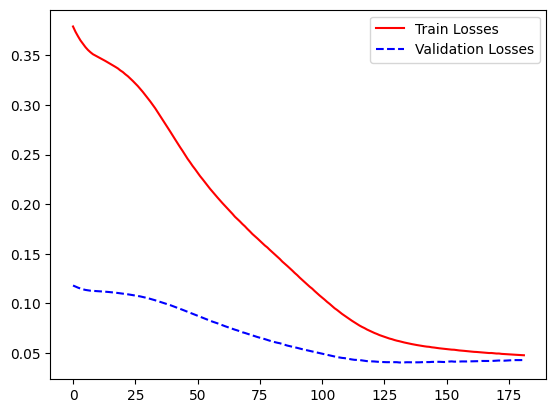

  0%|          | 0/1000 [00:00<?, ?it/s]

Early stopped on epoch: 331
Maximum Validation Accuracy is reached at epoch: 280


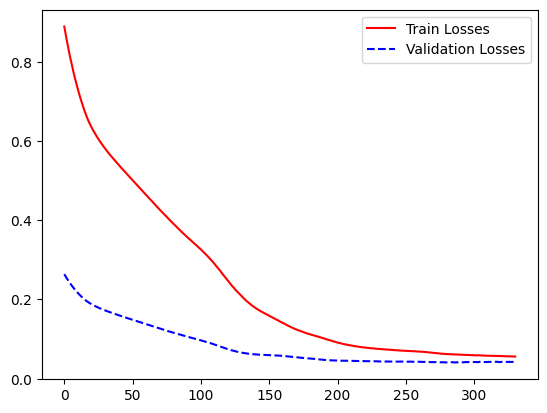

In [22]:
# @title Train MLPs

import pickle

output = []

# train the MLP with early stopping 5 times (to address the problem of getting stuck in local minima)
for i in range(5):
    model = MLP(40, 3, [8, 8, 8], nn.ReLU()) # Architecture can be varied to find the best model performance!
    loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)

    train_losses, val_losses, model, best_epoch, best_loss = early_stopping(1000, model, train_dataloader, val_dataloader, model_id =i)
    print(f'Maximum Validation Accuracy is reached at epoch: {best_epoch:2d}')

    # Visualise training and validation losses
    plt.plot(train_losses,'r-', label = 'Train Losses')
    plt.plot(val_losses,'b--', label = 'Validation Losses')
    plt.legend()
    plt.show()

    output.append((train_losses, val_losses, model, best_epoch, best_loss))

with open(folder_path+"best deep MLP_3*8_NtoP","wb") as file:
    pickle.dump(output, file)

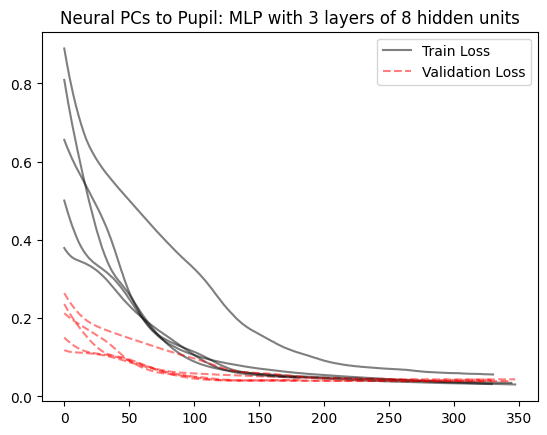

In [23]:
# @title Plot training and validation loss curves
with open(folder_path+"best deep MLP_3*8_NtoP", 'rb') as file:
    output = pickle.load(file)

for i in range(5):
    plt.plot(output[i][0], 'k-', alpha = 0.5)
    plt.plot(output[i][1], 'r--', alpha = 0.5)

plt.title('Neural PCs to Pupil: MLP with 3 layers of 8 hidden units')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

In [24]:
# @title Get test MSE losses, R2 from all NEURAL PCS -> PUPIL models

file_name = ['best deep MLP_1*8_NtoP',
             'best deep MLP_2*8_NtoP',
             'best deep MLP_3*8_NtoP',
             'best deep MLP_1*128_NtoP',
             'best deep MLP_2*128_NtoP',
             'best deep MLP_3*128_NtoP',
             'best deep MLP_1*256_NtoP']

NtoP_models = []

for i in range(len(file_name)):

  path = folder_path + file_name[i]

  train_losses = []
  test_losses_MSE = []
  test_losses_R2 = []

  with open(path, 'rb') as file:
      output = pickle.load(file)

  for j in range(5):

      train_loss = output[j][-1]
      model = output[j][2]

      loss = nn.MSELoss()

      test_loss_MSE = test(x_test, y_test, model, loss)
      test_loss_R2 = test_r2(x_test, y_test, model, loss)

      train_losses.append(train_loss)
      test_losses_MSE.append(test_loss_MSE)
      test_losses_R2.append(test_loss_R2)

  loss_summary = {
        'file_name': file_name[i],
        'train_losses': train_losses,
        'test_losses_MSE': test_losses_MSE,
        'test_losses_R2': test_losses_R2
  }

  NtoP_models.append(loss_summary)

file_name = 'NtoP_models'
path = folder_path + file_name

with open(path, 'wb') as file:
  pickle.dump(NtoP_models, file)

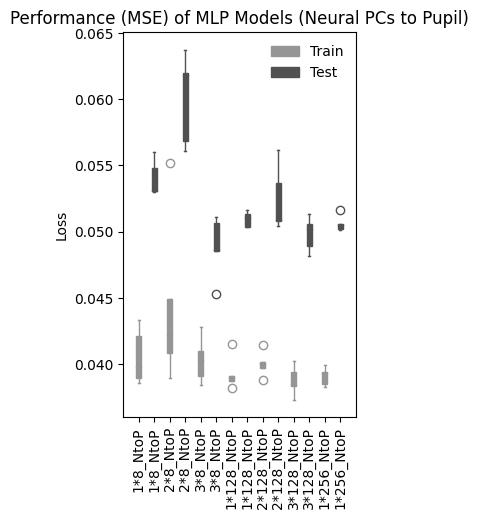

In [25]:
# @title Boxplot for MSE losses (Neural PCs to pupil)
with open(folder_path+"NtoP_models", 'rb') as file:
    output = pickle.load(file)

file_names_list = [model['file_name'] for model in output]
train_losses_list = [model['train_losses'] for model in output]
test_losses_list = [model['test_losses_MSE'] for model in output]
test_losses_R2_list = [model['test_losses_R2'] for model in output]

fig,ax = plt.subplots(1,1,figsize=(3,5))

for i in range(len(output)):
    c = plt.cm.Greys(0.50)
    ax.boxplot([train_losses_list[i]],positions=[i],labels=["_".join(file_names_list[i].split('_')[1:])],
                notch=False, patch_artist=True,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c))
    c = plt.cm.Greys(0.75)
    ax.boxplot([test_losses_list[i]],positions=[i+0.5],labels=["_".join(file_names_list[i].split('_')[1:])],
               notch=False, patch_artist=True,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),)

ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(),rotation=90)

import matplotlib.patches as mpatches

train_patch = mpatches.Patch(color=plt.cm.Greys(0.50), label='Train')
test_patch = mpatches.Patch(color=plt.cm.Greys(0.75), label='Test')
plt.legend(handles=[train_patch,test_patch], frameon=False)

plt.title('Performance (MSE) of MLP Models (Neural PCs to Pupil)')

# Add y-axis label
plt.ylabel('Loss')

# Show the plot
plt.show()

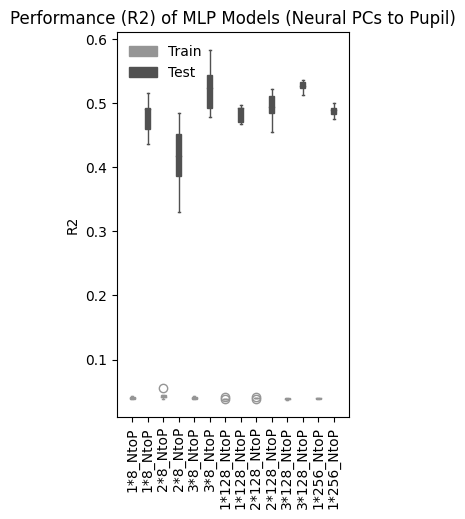

In [26]:
# @title Boxplot for R2 (Neural PCs to pupil)
with open(folder_path+"NtoP_models", 'rb') as file:
    output = pickle.load(file)

file_names_list = [model['file_name'] for model in output]
train_losses_list = [model['train_losses'] for model in output]
test_losses_list = [model['test_losses_MSE'] for model in output]
test_losses_R2_list = [model['test_losses_R2'] for model in output]

fig,ax = plt.subplots(1,1,figsize=(3,5))

for i in range(len(output)):
    c = plt.cm.Greys(0.50)
    ax.boxplot([train_losses_list[i]],positions=[i],labels=["_".join(file_names_list[i].split('_')[1:])],
                notch=False, patch_artist=True,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c))
    c = plt.cm.Greys(0.75)
    ax.boxplot([test_losses_R2_list[i]],positions=[i+0.5],labels=["_".join(file_names_list[i].split('_')[1:])],
               notch=False, patch_artist=True,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),)

ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(),rotation=90)

import matplotlib.patches as mpatches

train_patch = mpatches.Patch(color=plt.cm.Greys(0.50), label='Train')
test_patch = mpatches.Patch(color=plt.cm.Greys(0.75), label='Test')
plt.legend(handles=[train_patch,test_patch], frameon=False)

plt.title('Performance (R2) of MLP Models (Neural PCs to Pupil)')

# Add y-axis label
plt.ylabel('R2')

# Show the plot
plt.show()

In [27]:
# @title Get test MSE losses, R2 from all PUPIL -> NEURAL PCS models
file_name = ['best deep MLP_1*40_PtoN',
             'best deep MLP_4*40_PtoN',
             'best deep MLP_10*100_PtoN']

PtoN_models = []

for i in range(len(file_name)):

  path = folder_path + file_name[i]

  train_losses = []
  test_losses_MSE = []
  test_losses_R2 = []

  with open(path, 'rb') as file:
      output = pickle.load(file)

  for j in range(5):

      train_loss = output[j][-1]
      model = output[j][2]

      loss = nn.MSELoss()

      test_loss_MSE = test(x_test, y_test, model, loss)
      test_loss_R2 = test_r2(x_test, y_test, model, loss)

      train_losses.append(train_loss)
      test_losses_MSE.append(test_loss_MSE)
      test_losses_R2.append(test_loss_R2)

  loss_summary = {
        'file_name': file_name[i],
        'train_losses': train_losses,
        'test_losses_MSE': test_losses_MSE,
        'test_losses_R2': test_losses_R2
  }

  PtoN_models.append(loss_summary)

file_name = 'PtoN_models'
path = folder_path + file_name

with open(path, 'wb') as file:
  pickle.dump(PtoN_models, file)

RuntimeError: ignored

In [ ]:
# @title Boxplot for MSE losses (Pupil to Neural PCs)
with open(folder_path+"PtoN_models", 'rb') as file:
    output = pickle.load(file)

file_names_list = [model['file_name'] for model in output]
train_losses_list = [model['train_losses'] for model in output]
test_losses_list = [model['test_losses_MSE'] for model in output]
test_losses_R2_list = [model['test_losses_R2'] for model in output]

fig,ax = plt.subplots(1,1,figsize=(3,5))

for i in range(len(output)):
    c = plt.cm.Greys(0.50)
    ax.boxplot([train_losses_list[i]],positions=[i],labels=["_".join(file_names_list[i].split('_')[1:])],
                notch=False, patch_artist=True,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c))
    c = plt.cm.Greys(0.75)
    ax.boxplot([test_losses_list[i]],positions=[i+0.5],labels=["_".join(file_names_list[i].split('_')[1:])],
               notch=False, patch_artist=True,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),)

ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(),rotation=90)

import matplotlib.patches as mpatches

train_patch = mpatches.Patch(color=plt.cm.Greys(0.50), label='Train')
test_patch = mpatches.Patch(color=plt.cm.Greys(0.75), label='Test')
plt.legend(handles=[train_patch,test_patch], frameon=False)

plt.title('Performance (MSE) of MLP Models (Pupil to Neural PCs)')

# Add y-axis label
plt.ylabel('Loss')

# Show the plot
plt.show()

In [ ]:
!pip install brokenaxes

In [ ]:
# @title Boxplot for R2 (Pupil to Neural PCs)

with open(folder_path+"PtoN_models", 'rb') as file:
    output = pickle.load(file)

file_names_list = [model['file_name'] for model in output]
train_losses_list = [model['train_losses'] for model in output]
test_losses_list = [model['test_losses_MSE'] for model in output]
test_losses_R2_list = [model['test_losses_R2'] for model in output]

fig,ax = plt.subplots(1,1,figsize=(3,5))

for i in range(len(output)):
    c = plt.cm.Greys(0.50)
    ax.boxplot([train_losses_list[i]],positions=[i],labels=["_".join(file_names_list[i].split('_')[1:])],
                notch=False, patch_artist=True,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c))
    c = plt.cm.Greys(0.75)
    ax.boxplot([test_losses_R2_list[i]],positions=[i+0.5],labels=["_".join(file_names_list[i].split('_')[1:])],
               notch=False, patch_artist=True,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),)

ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(),rotation=90)

import matplotlib.patches as mpatches

train_patch = mpatches.Patch(color=plt.cm.Greys(0.50), label='Train')
test_patch = mpatches.Patch(color=plt.cm.Greys(0.75), label='Test')
plt.legend(handles=[train_patch,test_patch], frameon=False)

plt.title('Performance (R2) of MLP Models (Pupil to Neural PCs)')

# Add y-axis label
plt.ylabel('R2')

# Show the plot
plt.show()

In [ ]:
# @title Get test MSE losses, R2 from all NEURAL SPIKES -> PUPIL models
file_name = ['best deep MLP_1*32_StoP',
             'best deep MLP_2*32_StoP']

StoP_models = []

for i in range(len(file_name)):

  path = folder_path + file_name[i]

  train_losses = []
  test_losses_MSE = []
  test_losses_R2 = []

  with open(path, 'rb') as file:
      output = pickle.load(file)

  print(output)

  for j in range(5):

      train_loss = output[j][-1]
      model = output[j][2]

      loss = nn.MSELoss()

      test_loss_MSE = test(x_test, y_test, model, loss)
      test_loss_R2 = test_r2(x_test, y_test, model, loss)

      train_losses.append(train_loss)
      test_losses_MSE.append(test_loss_MSE)
      test_losses_R2.append(test_loss_R2)

  loss_summary = {
        'file_name': file_name[i],
        'train_losses': train_losses,
        'test_losses_MSE': test_losses_MSE,
        'test_losses_R2': test_losses_R2
  }

  StoP_models.append(loss_summary)

file_name = 'StoP_models'
path = folder_path + file_name

with open(path, 'wb') as file:
  pickle.dump(StoP_models, file)

In [ ]:
# @title Boxplot for MSE losses (neural spikes to pupil)
with open(folder_path+"StoP_models", 'rb') as file:
    output = pickle.load(file)

file_names_list = [model['file_name'] for model in output]
train_losses_list = [model['train_losses'] for model in output]
test_losses_list = [model['test_losses_MSE'] for model in output]
test_losses_R2_list = [model['test_losses_R2'] for model in output]

fig,ax = plt.subplots(1,1,figsize=(3,5))

for i in range(len(output)):
    c = plt.cm.Greys(0.50)
    ax.boxplot([train_losses_list[i]],positions=[i],labels=["_".join(file_names_list[i].split('_')[1:])],
                notch=False, patch_artist=True,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c))
    c = plt.cm.Greys(0.75)
    ax.boxplot([test_losses_list[i]],positions=[i+0.5],labels=["_".join(file_names_list[i].split('_')[1:])],
               notch=False, patch_artist=True,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),)

ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(),rotation=90)

import matplotlib.patches as mpatches

train_patch = mpatches.Patch(color=plt.cm.Greys(0.50), label='Train')
test_patch = mpatches.Patch(color=plt.cm.Greys(0.75), label='Test')
plt.legend(handles=[train_patch,test_patch], frameon=False)

plt.title('Performance (MSE) of MLP Models (Spikes to Pupil)')

# Add y-axis label
plt.ylabel('Loss')

# Show the plot
plt.show()

In [ ]:
# @title Boxplot for R2 (neural spikes to pupil)
with open(folder_path+"StoP_models", 'rb') as file:
    output = pickle.load(file)

file_names_list = [model['file_name'] for model in output]
train_losses_list = [model['train_losses'] for model in output]
test_losses_list = [model['test_losses_MSE'] for model in output]
test_losses_R2_list = [model['test_losses_R2'] for model in output]

fig,ax = plt.subplots(1,1,figsize=(3,5))

for i in range(len(output)):
    c = plt.cm.Greys(0.50)
    ax.boxplot([train_losses_list[i]],positions=[i],labels=["_".join(file_names_list[i].split('_')[1:])],
                notch=False, patch_artist=True,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c))
    c = plt.cm.Greys(0.75)
    ax.boxplot([test_losses_R2_list[i]],positions=[i+0.5],labels=["_".join(file_names_list[i].split('_')[1:])],
               notch=False, patch_artist=True,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),)

ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(),rotation=90)

import matplotlib.patches as mpatches

train_patch = mpatches.Patch(color=plt.cm.Greys(0.50), label='Train')
test_patch = mpatches.Patch(color=plt.cm.Greys(0.75), label='Test')
plt.legend(handles=[train_patch,test_patch], frameon=False)

plt.title('Performance (R2) of MLP Models (Spikes to Pupil)')

# Add y-axis label
plt.ylabel('R2')

# Show the plot
plt.show()